In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import yaml
import sys
import subprocess
import math

## Parallel focusing 
function which looks for the best setup of magnets to focus beam with some input parameters (energy and other initial parameters) into a parallel focused beam. The setup of magnets consists of 3 permanent quadrupole magnets which are positioned one after another. Because they are permanent, the only varying parameters are the distances between them. Function RefParticles() runs only 5 reference particles, Beam() function runs the whole beam.

In [61]:
fileName = "parallelBeam"
fillNumber = "001"
setupLength = 2 #m
setupLengthStr = "0200"
longitudalEnergy = "5.0E+8" #eV


#parameters of magnets 
lengthQ1 = 0.036  #m
lengthQ2 = 0.12  #m
lengthQ3 = 0.1  #m

boreQ1 = 0.007
boreQ2 = 0.018
boreQ3 = 0.030

#offsets and angles for reference particles
xoffset = "2.0E-4" #m
yoffset =  "2.0E-4" #m
xmom = "1.0E+6" #eV
ymom = "1.0E+6" #eV


#input parameters of the beam
nParticles = "500"
sig_x=0.75E0  #gaussian distribution in x direction with this sigma
sig_y=0.75E0
sig_px = 0.075E0
sig_py = 0.075E0


In [62]:
dataD1 = []
dataD2 = []
dataD3 = []
dataMom = []
dataSumX = []
dataSumY = []

Files test0.ini all the way to test4.ini are input data for 5 different runs. File test0.ini has 0. reference particle with 0 offset and 0 initial angle, 1 and 2 have offsets in the x and y directions respectively and the last 2 have predefined angles. All of them should be parallel in the end.

In [63]:
def changeInputData(tag, newVar):
#universal function which changes input parameter in input file to Astra
    try:
        # Open the file for reading
        with open(fileName + ".in", 'r') as file:
            lines = file.readlines()

        # Prepare the replacement string
        replacement = " " + tag + "=" + newVar + "\n"

        # Iterate over the lines to find and replace the target line
        for i, line in enumerate(lines):
            if tag in line:
                lines[i] = replacement
                break  # Assuming there's only one occurrence to replace

        # Write the modified lines back to the file
        with open(fileName + ".in", 'w') as file:
            file.writelines(lines)

        #print(f"Replaced '{tag}' with '{replacement.strip()}'.")

    except FileNotFoundError:
        print("The file " + fileName + ".ini was not found.")
    except Exception as e:
        print(f"An error occurred when trying to change '{tag}' to variable '{newVar}': {e}")


    
    return

In [64]:
def topHatShapedQuads(ideal):
    #switcher between idealised quadrupoles without fringe fields or not
    if ideal:
        changeInputData("Q_bore{1}", "1E-9")
        changeInputData("Q_bore{2}", "1E-9")
        changeInputData("Q_bore{3}", "1E-9")
    else: 
        changeInputData("Q_bore{1}", str(boreQ1))
        changeInputData("Q_bore{2}", str(boreQ2))
        changeInputData("Q_bore{3}", str(boreQ3))

    return       

In [65]:
def changeMomZ(momZ):
    try:
        testData = ""
        #change longitudinal momentum for files test0.ini through test4.ini and test.ini
        inputData0 = "  0.0000E+0  0.0000E+00  0.0000E+00  0.0000E+00  0.0000E+00  " + str(momZ) + "  0.0000E+00 -1.0000E-01   1   5"
        testData += inputData0 + "\n"
        with open("test0.ini", "w") as file:
            file.write(inputData0)
        
        inputData1 = "  " + xoffset + "  0.0000E+00  0.0000E+00  0.0000E+00  0.0000E+00  " + str(momZ) + "  0.0000E+00 -1.0000E-01   1   5"
        testData += inputData1 + "\n"
        with open("test1.ini", "w") as file:
            file.write(inputData1)
    
        inputData2 = "  0.0000E+00  " + yoffset + "  0.0000E+00  0.0000E+00  0.0000E+00  " + str(momZ) + "  0.0000E+00 -1.0000E-01   1   5"
        testData += inputData2 + "\n"
        with open("test2.ini", "w") as file:
            file.write(inputData2)
    
        inputData3 = "  0.0000E+00  0.0000E+00  0.0000E+00 " + xmom + " 0.0000E+00  " + str(momZ) + "  0.0000E+00 -1.0000E-01   1   5"
        testData += inputData3 + "\n"
        with open("test3.ini", "w") as file:
            file.write(inputData3)
    
        inputData4 = "  0.0000E+00  0.0000E+00  0.0000E+00  0.0000E+00 " + ymom + "  " + str(momZ) + "  0.0000E+00 -1.0000E-01   1   5"
        testData += inputData4 + "\n"    
        with open("test4.ini", "w") as file:
            file.write(inputData4)   
    
        with open("test.ini","w") as file:
            file.write(testData)
    
        #generate new data with new momentum
        changeInputData("Ref_Ekin", str(momZ))
        subprocess.run("./generator " + fileName + " > output.txt" , shell=True,check=True,executable='/bin/bash' )
        #print(f"Successfully changed momentum to files and ran a generation of particles saved to '{fileName}'.")

    except FileNotFoundError:
        print("One of the files when changing longitudinal momentum was not found.")
    except Exception as e:
        print(f"An error occurred when trying to change longitudinal momentum: {e}")

    return
    

In [66]:
def update():
    
    inputData = "  " + xoffset + "  0.0000E+00  0.0000E+00  0.0000E+00  0.0000E+00  5.0000E+08  0.0000E+00 -1.0000E-01   1   5"
    with open("test1.ini", "w") as file:
        file.write(inputData)

    inputData = "  0.0000E+00  " + yoffset + "  0.0000E+00  0.0000E+00  0.0000E+00  5.0000E+08  0.0000E+00 -1.0000E-01   1   5"
    with open("test2.ini", "w") as file:
        file.write(inputData)

    inputData = "  0.0000E+00  0.0000E+00  0.0000E+00 " + xmom + " 0.0000E+00  5.0000E+08  0.0000E+00 -1.0000E-01   1   5"
    with open("test3.ini", "w") as file:
        file.write(inputData)

    inputData = "  0.0000E+00  0.0000E+00  0.0000E+00  0.0000E+00 " + ymom + " 5.0000E+08  0.0000E+00 -1.0000E-01   1   5"
    with open("test4.ini", "w") as file:
        file.write(inputData)   

    #change input energy
    changeInputData("Ref_Ekin", longitudalEnergy)
    changeInputData("ZSTOP", str(setupLength) )

    #change properties of magnets
    changeInputData("Q_length(1)", str(lengthQ1))
    changeInputData("Q_length(2)", str(lengthQ2))
    changeInputData("Q_length(3)", str(lengthQ3))
    
    #change parameters of the beam
    changeInputData("IPart", str(nParticles))

    changeInputData("sig_x", str(sig_x))
    changeInputData("sig_y", str(sig_y))
    changeInputData("sig_px", str(sig_px))
    changeInputData("sig_py", str(sig_py))

    dataD1.clear()
    dataD2.clear()
    dataD3.clear()
    dataSumX.clear()
    dataSumY.clear()
    
    print(f"Succesfully updated all variables.")

    return

In [67]:
def isRef0Straight(px, py):
    #function which checks if 0. ref particle did not move
    if px == 0 and py == 0:
        return True
    else:
        return False

In [68]:
def differLine(line):
    lineSplitted = line.split()
    
    return [float(num) for num in lineSplitted]    

In [69]:
def loadDataRef(arg):
#open and load data about reference particle
#z [m], t [ns], pz [MeV/c], dE/dz [MeV/c], Larmor Angle [rad], x off [mm], y off [mm], px [eV/c], py [eV/c]
    data = []
    #assuming setup length
    with open(fileName + "." + arg + "." + fillNumber,"r") as file:
        for line in file:
            newLine = differLine(line)
            data.append(newLine)

    return data
    

In [70]:
def runRef(D1, D2, D3,momZ, moreData):
    #this function runs Astra with 5 different reference particles for specific D1,D2,D3

    
    Q1pos = D1 + lengthQ1/2 + 3*boreQ1
    Q2pos = D1 + lengthQ1 + D2 + lengthQ2/2 + 6*boreQ1 + 3*boreQ2
    Q3pos = D1 + lengthQ1 + D2 + lengthQ2 + D3 + lengthQ3/2 + 6*boreQ1 + 6*boreQ2 + 3*boreQ3
    
    changeInputData("Q_pos(1)",str(Q1pos))
    changeInputData("Q_pos(2)",str(Q2pos) )
    changeInputData("Q_pos(3)",str(Q3pos) )
    changeMomZ(momZ)


    #if moreData, then provide tracking for each of the reference particles and return it for plotting
    if moreData:
        inputDataName = ["test0.ini", "test1.ini", "test2.ini", "test3.ini", "test4.ini"]
        outputMoreData = []
        for i in range(5):
            changeInputData("Distribution", inputDataName[i] )
            subprocess.run("source /opt/intel/oneapi/setvars.sh > out.txt && ./Astra " + fileName + " >> output.txt", shell=True,check=True,executable='/bin/bash' )
            currentData = loadDataRef("ref")
            
            #condition for 0. ref particle-> it cannot move
            if i == 0 and not isRef0Straight(currentData[-1][7], currentData[-1][8]):
                print(f"Reference 0 particle with 0 offset and 0 angle moved in setup with D1 = '{D1}', D2 = '{D2}' and D3 = '{D3}'.")
                return 1
                
            #condition to check if the particle came all the way to the end
            distFromEnd = math.fabs(currentData[-1][0] - setupLength)
            if distFromEnd > 0.1:
                print(f"Reference particle '{i}' did not get to the end in setup with D1 = '{D1}', D2 = '{D2}' and D3 = '{D3}'. ")
                return 1
            
            outputMoreData.append(currentData)

        return outputMoreData

    else:
        subprocess.run("source /opt/intel/oneapi/setvars.sh > out.txt && ./Astra " + fileName + " > output.txt", shell=True,check=True,executable='/bin/bash' )
        outputData = loadDataRef(setupLengthStr)
        
        #condition for 0. ref particle-> it cannot move
        if not isRef0Straight(outputData[0][3], outputData[0][4]):
            print(f"Reference 0. particle with 0 offset and 0 angle moved in setup with D1 = '{D1}', D2 = '{D2}' and D3 = '{D3}'.")
            return 1
                
        #condition to check if all particles came all the way to the end
        for j,row in enumerate(outputData):
            
            #z position for 1. particle, z positions of other particles relative to the 1. one
            distFromEnd = 0
            if j == 0:
                distFromEnd = math.fabs(outputData[j][2] - setupLength)
            else:
                distFromEnd = math.fabs(outputData[j][2] * outputData[0][2])
            if distFromEnd > 0.1:
                print(f"Reference particle '{j}' did not get to the end in setup with D1 = '{D1}', D2 = '{D2}' and D3 = '{D3}'. Distance from the end = '{distFromEnd}'. ")
                return 1  

        return outputData

In [100]:
def angleCalculationX(data):
#calculate angle of particles in mrad and sum up x and y direction in squares
    
    sum = math.fabs(data[3][3]/data[3][5])
    return sum

In [101]:
def angleCalculationY(data):
#calculate angle of particles in mrad and sum up x and y direction in squares
    
    sum = math.fabs(data[4][4]/data[4][5])
    
    return sum

In [73]:
def fill4DGraph(D1, D2,D3,mom,sumX, sumY):
    dataD1.append(D1)
    dataD2.append(D2)
    dataD3.append(D3)
    dataMom.append(mom)
    dataSumX.append(sumX)
    dataSumY.append(sumY)
    
    return

In [74]:
def giveRange(rangeVar, nInt):
    #function to determine whether a variable will be varied or not, if yes then determine the range
    output = []
    if rangeVar[0] != rangeVar[1]:
        interval =(rangeVar[1] - rangeVar[0])/nInt      
        for i in range(nInt):
            output.append(rangeVar[0] + i*interval)
    else:
        output.append(rangeVar[0])

    return output


In [96]:
def refParticles(D1_range, D2_range, D3_range, mom_range, nInt):

    update()
    
    D1 = giveRange(D1_range, nInt)
    D2 = giveRange(D2_range, nInt)
    D3 = giveRange(D3_range, nInt)
    mom = giveRange(mom_range, nInt)

    #test.ini file contains 5 reference particles
    changeInputData("Distribution", "test.ini" )


    bestSetupX = [0.5, 0.5, 0.5, 3E+8] 
    minSumX = 1e+9 #initial guess of sum of angles in x,y directions
    bestSetupY = [0.5, 0.5, 0.5, 3E+8] 
    minSumY = 1e+9 #initial guess of sum of angles in x,y directions
    
    #3 cycles which run through all ranges of D1, D2, D3
    for D1_current in D1:
        print(f"Running D1 = '{D1_current}'... ")
        for D2_current in D2:
            for D3_current in D3:
                for mom_current in mom:
                    dataCurrent = runRef(D1_current, D2_current, D3_current, mom_current, False)
                    if dataCurrent == 1:
                         continue
                    sumX = angleCalculationX(dataCurrent)
                    sumY = angleCalculationY(dataCurrent)
                    fill4DGraph(D1_current, D2_current, D3_current, mom_current, sumX, sumY)
                            
                    print(f"Angle sumX: '{sumX}', Angle sumY: '{sumY}'.")
                    #in case of finding the exact solution
                    if sumX == 0:
                        print(f"Found a solution for X!! Sum equals 0.")
                        bestSetup = [D1_current, D2_current, D3_current, mom_current]
                        return bestSetup
                        
                    if sumY == 0:
                        print(f"Found a solution for Y!! Sum equals 0.")
                        bestSetup = [D1_current, D2_current, D3_current, mom_current]
                        return bestSetup
                           
                    if sumX <= minSumX:
                        minSumX = sumX
                        bestSetupX = [D1_current, D2_current, D3_current, mom_current]

                    if sumY <= minSumY:
                        minSumY = sumY
                        bestSetupY = [D1_current, D2_current, D3_current, mom_current]
                        
        
        print(f"finished it")
    
    print(f"Finished loop")
    print(f"best y setup: '{bestSetupY}'.")
    print(f"best x setup: '{bestSetupX}'.")
    

    bestSetup = []
    bestSetup.append(bestSetupX)
    bestSetup.append(bestSetupY)
    
    return bestSetup


In [76]:
def separateDataXYZ(data):

    z0 = []
    x0 = []
    y0 = []
    for element in data:
        z0.append(element[0])
        x0.append(element[5])
        y0.append(element[6])
        
    XYZ = []
    XYZ.append(x0)
    XYZ.append(y0)
    XYZ.append(z0)
    
    return XYZ

In [77]:
def plotRefXY(D1, D2, D3, mom):

    print(f"Running best setup again to get full data.")
    dataBest = runRef(D1, D2, D3, mom, True)

    data0 = separateDataXYZ(dataBest[0])
    data1 = separateDataXYZ(dataBest[1])
    data2 = separateDataXYZ(dataBest[2])
    data3 = separateDataXYZ(dataBest[3])
    data4 = separateDataXYZ(dataBest[4])


    plt.plot(data0[2], data0[0], label='0 offset, 0 angle', color='blue')
    plt.plot(data1[2], data1[0], label='x offset, 0 angle', color='green')
    plt.plot(data2[2], data2[0], label='y offset, 0 angle', color='red')
    plt.plot(data3[2], data3[0], label='0 offset, x angle', color='yellow')
    plt.plot(data4[2], data4[0], label='0 offset, y angle', color='purple')

    plt.legend()

    plt.xlabel("z [m]")
    plt.ylabel("x_offset [mm]")
    plt.title(f"x offset along z('{D1}', '{D2}', '{D3}')")

    plt.show()


    
    plt.plot(data0[2], data0[1], label='0 offset, 0 angle', color='blue')
    plt.plot(data1[2], data1[1], label='x offset, 0 angle', color='green')
    plt.plot(data2[2], data2[1], label='y offset, 0 angle', color='red')
    plt.plot(data3[2], data3[1], label='0 offset, x angle', color='yellow')
    plt.plot(data4[2], data4[1], label='0 offset, y angle', color='purple')

    plt.legend()

    plt.xlabel("z [m]")
    plt.ylabel("y_offset [mm]")
    plt.title(f"y offset along z('{D1}', '{D2}', '{D3}')")

    plt.show()
    
    return

In [78]:
def plot_4d_data(XorY):

    dataSum = []
    if XorY == "X":
        dataSum = dataSumX
    else:
        dataSum = dataSumY
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    # Scatter plot
    scatter = ax.scatter(dataD1, dataD2, dataD3, c=dataSum, cmap='viridis')
    
    # Add color bar to indicate the values of the 4th dimension
    color_bar = plt.colorbar(scatter, ax=ax, pad=0.1)
    color_bar.set_label('4th Dimension')
    
    # Labels and plot title
    ax.set_xlabel('D1 [m]')
    ax.set_ylabel('D2 [m]')
    ax.set_zlabel('D3 [m]')
    plt.title('function of angle sum for ' + XorY + ' focusing')
    
    plt.show()


    plt.plot(dataD1, dataSum, label='D1', color='blue')
    plt.legend()
    plt.xlabel("D1 [m]")
    plt.ylabel("sum [mrad]")
    plt.title(f"Function of varying D1 with constant D2, D3, momentum")
    plt.show()
    
    return

In [105]:
D1_range = [0.62,0.68]
D2_range = [0.13,0.13] #constant for now
D3_range = [0.13,0.13]
mom_range = [6.8E+8, 7.2E+8]
nIntervals = 30

topHatShapedQuads(True)

best = refParticles(D1_range,D2_range, D3_range, mom_range, nIntervals)
bestX = []
bestY = []
if len(best) == 2:
    bestX = best[0]
    besty = best[1]
    print(f"Best setup for focusing in the x direction: '{bestX}'. ")
    print(f"Best setup for focusing in the y direction: '{bestY}'. ")
print(best)

plotRefXY(*bestX) 
plotRefXY(0.678, 0.13,0.13,680000000) 

Succesfully updated all variables.
Running D1 = '0.62'... 
Angle sumX: '2.096029411764706e-05', Angle sumY: '0.0005485735294117647'.
Angle sumX: '2.4286322340128867e-05', Angle sumY: '0.0005533441944432214'.
Angle sumX: '2.7588732476892204e-05', Angle sumY: '0.0005580295018090732'.
Angle sumX: '3.086549707602339e-05', Angle sumY: '0.0005626754385964913'.
Angle sumX: '3.4119329374170106e-05', Angle sumY: '0.0005672595683831147'.
Angle sumX: '3.734690608298018e-05', Angle sumY: '0.0005717739234275561'.


KeyboardInterrupt: 

[[0.656, 0.13, 0.13, 689333333.3333334], [0.678, 0.13, 0.13, 680000000.0]]
Running best setup again to get full data.


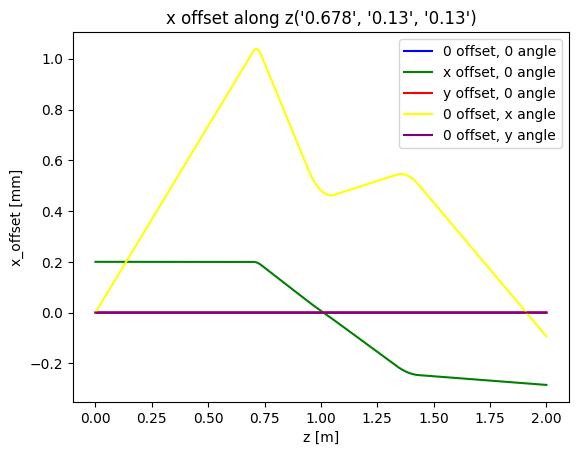

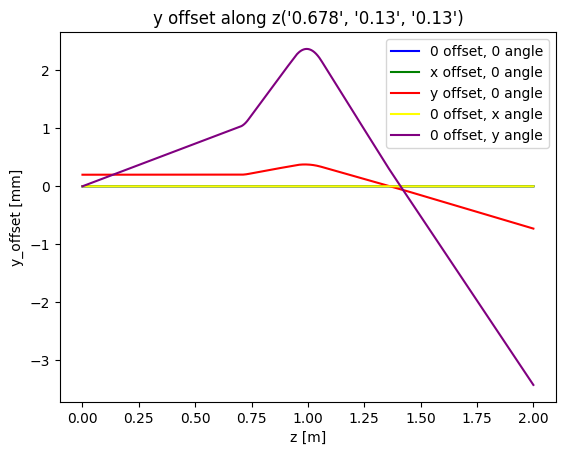

In [107]:
print(best)
plotRefXY(0.678, 0.13,0.13,680000000) 

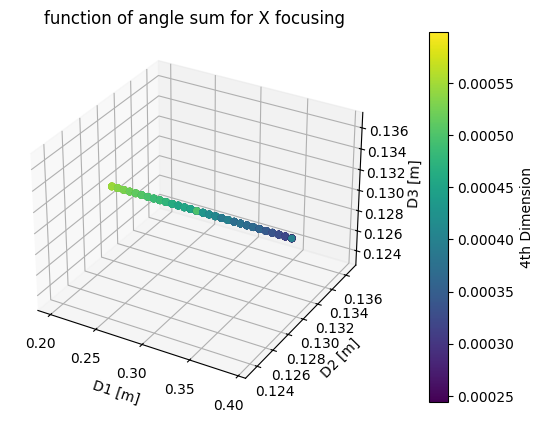

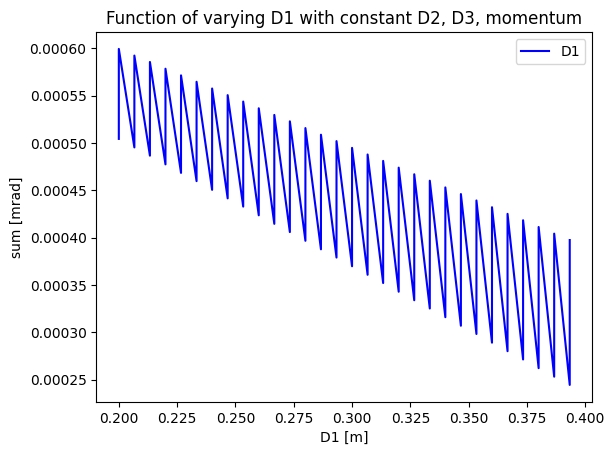

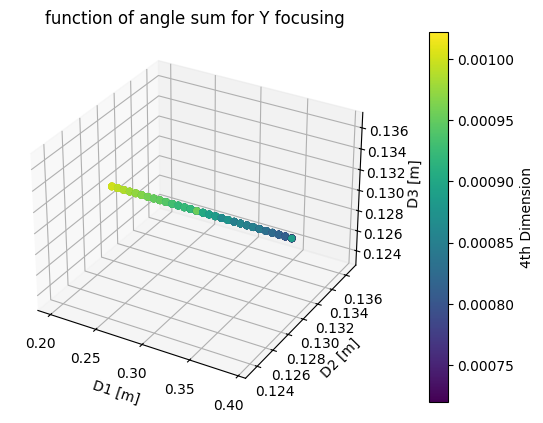

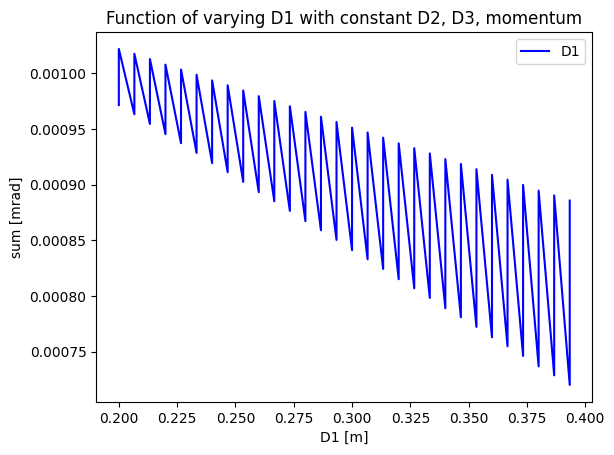

In [80]:
plot_4d_data("X")
plot_4d_data("Y")

In [36]:
def runBeam(D1,D2,D3, moreData):

    #change setup according to arguments  
    Q1pos = D1 + lengthQ1/2 + 3*boreQ1
    Q2pos = D1 + lengthQ1 + D2 + lengthQ2/2 + 6*boreQ1 + 3*boreQ2
    Q3pos = D1 + lengthQ1 + D2 + lengthQ2 + D3 + lengthQ3/2 + 6*boreQ1 + 6*boreQ2 + 3*boreQ3

    changeInputData("Q_pos(1)",str(Q1pos))
    changeInputData("Q_pos(2)",str(Q2pos) )
    changeInputData("Q_pos(3)",str(Q3pos) )

    

    
    subprocess.run("source /opt/intel/oneapi/setvars.sh > out.txt && ./Astra " + fileName + " >> output.txt" , shell=True,check=True,executable='/bin/bash' )

    #condition for 0. ref particle-> it cannot move
    with open(fileName + ".ref." + fillNumber,"r") as refFile:
        refData = refFile.readlines()
        
    if not (isRef0Straight(refData[-1][7], refData[-1][8]) and isRef0Straight(refData[-1][5], refData[-1][6])):
        print(f"Reference 0 particle with 0 offset and 0 angle moved in setup with D1 = '{D1}', D2 = '{D2}' and D3 = '{D3}'.")
        return 1
        
    #load beam data
    with open(fileName + ".Xemit." + fillNumber,"r") as fileX:
        xBeamData = fileX.readlines()
    xDivergence = float(xBeamData[-1][4])
        
    with open(fileName + ".Yemit." + fillNumber,"r") as fileY:
        yBeamData = fileY.readlines()
    yDivergence = float(yBeamData[-1][4])

    #here implement more conditions when each condition has it's own weight. For example on the diameter of the beam or longitudinal width

    
    sum = math.sqrt( xDivergence**2 + yDivergence**2)


    return sum

In [37]:
def Beam():
# function which each setup runs only once and looks at the outcome of all 
    update()

    #3 different variables- D1, D2, D3
    D1 = []
    D2 = []
    D3 = []

    #1/4 of the setup length will be divided into nIntervals
    interval = setupLength/(10*nIntervals)
    
    for i in range(nIntervals):
        D1.append(i*interval)
        D2.append(i*interval)
        D3.append(i*interval)
    
    bestD = [1,2,3] 
    minSum = 1e+7 #initial guess of sum of angles in x,y directions
    
    #3 cycles which run through all ranges of D1, D2, D3
    for D1_current in D1:
        print(f"Running D1 = '{D1_current}'... ")
        for D2_current in D2:
            for D3_current in D3:
                sum = runBeam(D1_current, D2_current, D3_current, False)
                if sum == 1:
                    continue
                #print(f"Momentum sum: '{momSum}'.")
                if sum <= minSum:
                    minSum = sum
                    bestD = {D1_current, D2_current, D3_current}
                    #print(f"Found a new temporary best setup with D1 = '{D1_current}', D2 = '{D2_current}', D3 = '{D3_current}'")

        print(f"finished it")
    
    print(f"Finished loop for beam")

    return bestD


In [ ]:
def plotBeam():
    #function that plots output of beam
    #what to plot?!

    





    return

In [19]:
bestBeamD = Beam()
plotBeam(*bestBeamD)

NameError: name 'Beam' is not defined